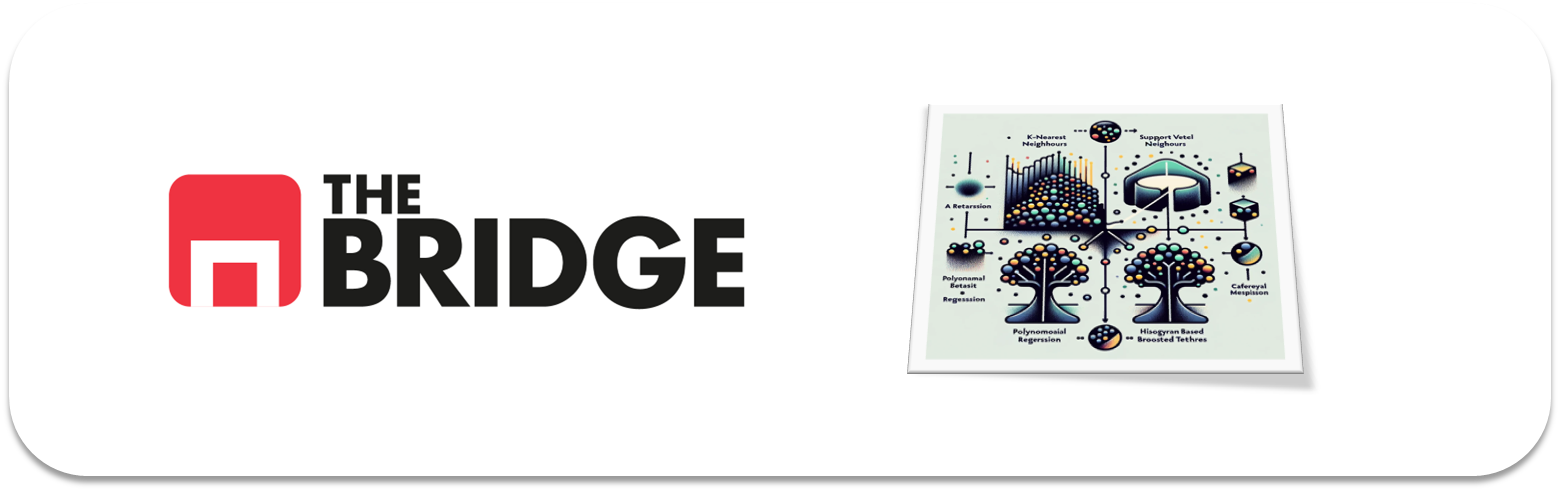

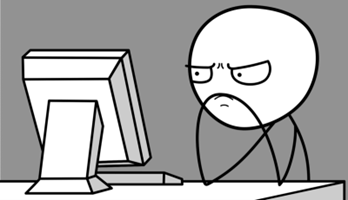

Para ejercitarte y afianzar lo aprendido sobre **Etapas Adicionales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import bootcampviztools as bvt
import toolbox_ML as tml

np.random.seed(42)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

### #1 Equilibrado de Datasets

### Ejercicio 1

Carga el dataset de los diamantes (está en el directorio "data") preparado ya para poder entrenar un modelo de clasificación. Muestra las primeras 7 filas y observa el listado de columnas. Muestra la distribución del potencial target ("cut") que ya conoces. ¿Está desbalanceada?

In [2]:
df = pd.read_csv("./data/diamonds_preparado.csv", sep = "|")
df.head(7)

,carat,cut,depth,table,price,x,y,z,color_D,color_E,...,color_I,color_J,clarity_IF,clarity_VVS1,clarity_VVS2,clarity_VS1,clarity_VS2,clarity_SI1,clarity_SI2,clarity_I1
0,0.23,Ideal,61.5,55.0,326,3.95,3.98,2.43,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0.21,Premium,59.8,61.0,326,3.89,3.84,2.31,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.23,Good,56.9,65.0,327,4.05,4.07,2.31,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0.29,Premium,62.4,58.0,334,4.20,4.23,2.63,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0.31,Good,63.3,58.0,335,4.34,4.35,2.75,0,0,...,0,1,0,0,0,0,0,0,1,0
5,0.24,Very Good,62.8,57.0,336,3.94,3.96,2.48,0,0,...,0,1,0,0,1,0,0,0,0,0
6,0.24,Very Good,62.3,57.0,336,3.95,3.98,2.47,0,0,...,1,0,0,1,0,0,0,0,0,0


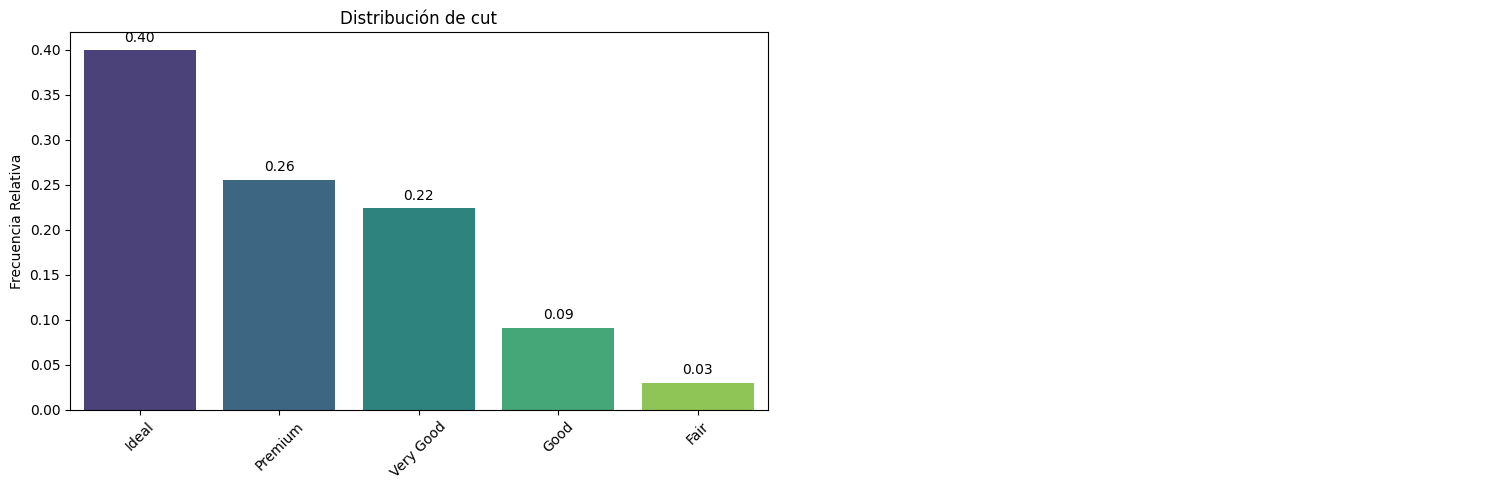

In [3]:
bvt.pinta_distribucion_categoricas(df, ["cut"], mostrar_valores=True, relativa=True)

In [4]:
target = "cut"

 ### Ejercicio 2

 Crea un train_set y un test_set al 20%, crea los pares X,y de train y test con el target en la variable "cut", considera el resto como features.

In [5]:
train_set, test_set = train_test_split(df, test_size = 0.2)

X_train = train_set.drop(columns=target)
X_test = test_set.drop(columns=target)

y_train = train_set.cut
y_test = test_set.cut

### Ejercicio 3

Instancia un modelo RandomForest con max_depth a 5 y sin tocar otro hiperparámetro, entrénalo con el X_train y el y_train. Y muestra el classification_report para el X_train.

In [6]:
rnd_for = RandomForestClassifier(max_depth=5)
rnd_for.fit(X_train,y_train)

y_pred_train = rnd_for.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

        Fair       0.90      0.62      0.73      1275
        Good       0.76      0.34      0.47      3902
       Ideal       0.79      0.94      0.86     17259
     Premium       0.58      0.87      0.70     11016
   Very Good       0.61      0.22      0.32      9700

    accuracy                           0.70     43152
   macro avg       0.73      0.60      0.62     43152
weighted avg       0.70      0.70      0.66     43152



### Ejercicio 4

Dado el desbalanceo, nos queremos fijar en el recall medio (la media del recall considerando cada clase). Usando "cross_val_score", hagamos una estimación un poco más precisa (y en general pesimista) de cual sería ese recall medio del modelo en general. Asigna para ello a `scoring` el valor `balanced_accuracy`

In [7]:
mean_recall = np.mean(cross_val_score(rnd_for, X_train, y_train, cv=5, scoring='balanced_accuracy', n_jobs=-1))
print(f'Recall media: {mean_recall}')

Recall media: 0.5995339413936596


### Ejercicio 5

El resultado obtenido en el ejercicio 4 es bueno o malo dependiendo de lo que "Negocio" nos diga. Supón que negocio nos dice que quiere como mínimo que cada clase tenga un 50% de recall (que al menos un 50% de cada clase de diamente se etiquete bien por el modelo). Viendo el report anterior seguro que ves que así no llegamos. Tenemos que hacer algo, ayudar al modelo a conseguir ese objetivo. ¿Cómo? Con las téncias de equilibrado. Empecemos por aumentar las clases minoritarias con SMOTE. 

Crea un X_train y un y_train balanceados aplicando SMOTE; muestra el reparto del y_train para ver que se ha balanceado en todas las clases

In [8]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [9]:
y_train_smote.value_counts(True)

cut
Good         0.2
Very Good    0.2
Premium      0.2
Ideal        0.2
Fair         0.2
Name: proportion, dtype: float64

In [10]:
print("Con SMOTE", y_train_smote.shape)
print("Sin SMOTE", y_train.shape)

Con SMOTE (86295,)
Sin SMOTE (43152,)


### Ejercicio 6

Entrena con el nuevo X,y y muestra los resultados del modelo así entrenado pero prediciendo contra el X_test creado en el ejercicio 2. Comenta el resultado. NOTA: En el caso de querer balancear con tecnicas de Oversampling y Undersampling, es interesante crear un set de validación adicional al de test y train, para no tener que usar el test como validación de los modelos.

In [11]:
rnd_for_smote = RandomForestClassifier(max_depth=5)
rnd_for_smote.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=5)

In [ ]:
y_pred_test = rnd_for_smote.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

        Fair       0.89      0.76      0.82       335
        Good       0.47      0.71      0.57      1004
       Ideal       0.79      0.93      0.85      4292
     Premium       0.62      0.82      0.70      2775
   Very Good       0.57      0.07      0.12      2382

    accuracy                           0.68     10788
   macro avg       0.67      0.66      0.61     10788
weighted avg       0.67      0.68      0.63     10788



### Ejercicio 7

Prueba ahora a mejorar el modelo empleando el hiperparámetro class_weight. Reinstancia el modelo, entrenalo contra el X_train inicial y luego muestra el report contra el test. Comenta brevemente el resultado.

In [13]:
rnd_for_bal = RandomForestClassifier(max_depth=5, class_weight="balanced")
rnd_for_bal.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5)

In [14]:
y_pred_bal = rnd_for_bal.predict(X_test)
print(classification_report(y_test, y_pred_bal))

              precision    recall  f1-score   support

        Fair       0.86      0.82      0.84       335
        Good       0.44      0.71      0.54      1004
       Ideal       0.79      0.92      0.85      4292
     Premium       0.61      0.78      0.69      2775
   Very Good       0.55      0.07      0.12      2382

    accuracy                           0.67     10788
   macro avg       0.65      0.66      0.61     10788
weighted avg       0.66      0.67      0.62     10788



### Ejercicio 8

Para terminar con nuestros intentos de mejorar la clasificación "global", vamos a aplicar el bajomuestreo de las clases mayoritarias, aunque no tengamos muchas esperanzas puestas en ello. Para poder hacerlo vamos a usar la clase `RandomUnderSampler` de la biblioteca imblearn. Investiga un poco sobre su funcionamiento (pista es equivalente en su uso a la clase Smote) y crea un dataset con undersampling de forma que las clases estén equilibradas. Muestra las frecuencias del target. ¿Por qué no tenemos muchas expectativas, en este caso, sobre esta técnica? 

In [17]:
under = RandomUnderSampler()
X_train_under, y_train_under = under.fit_resample(X_train, y_train)
y_train_under.value_counts()

cut
Fair         1275
Good         1275
Ideal        1275
Premium      1275
Very Good    1275
Name: count, dtype: int64

In [18]:
print("Con RandomUnderSampler", y_train_under.shape)
print("Sin RandomUnderSampler", y_train.shape)

Con RandomUnderSampler (6375,)
Sin RandomUnderSampler (43152,)


### Ejercicio 9

Entrena, ahora con class_weight a None, un RandomForest como el inicial pero contra el train creado en el ejercicio 8, muestra su informe de clasificación sobre la predicción contra test y comenta el resultado.

In [19]:
rnd_for_under = RandomForestClassifier(max_depth=5, class_weight=None)
rnd_for_under.fit(X_train_under,y_train_under)

RandomForestClassifier(max_depth=5)

In [20]:
y_pred_under = rnd_for_under.predict(X_test)
print(classification_report(y_test,y_pred_under))

              precision    recall  f1-score   support

        Fair       0.82      0.85      0.84       335
        Good       0.54      0.67      0.59      1004
       Ideal       0.79      0.93      0.85      4292
     Premium       0.61      0.85      0.71      2775
   Very Good       0.59      0.07      0.12      2382

    accuracy                           0.69     10788
   macro avg       0.67      0.67      0.62     10788
weighted avg       0.68      0.69      0.63     10788



### #2 Análisis de Errores

### Ejercicio 10

Muestra la matriz de confusión con "ConfusionMatrixDisplay.from_predictions" para el clasificador entrenado con el hiperparámetro class_weight con el valor "balanced" (el del ejercicio 7). Asigna el valor "true" (ojo es un string, no el booleano True) al argumento normalize. Comenta que estamos viendo y hacia donde se dirigen los errores de clasificación de "Very Good"

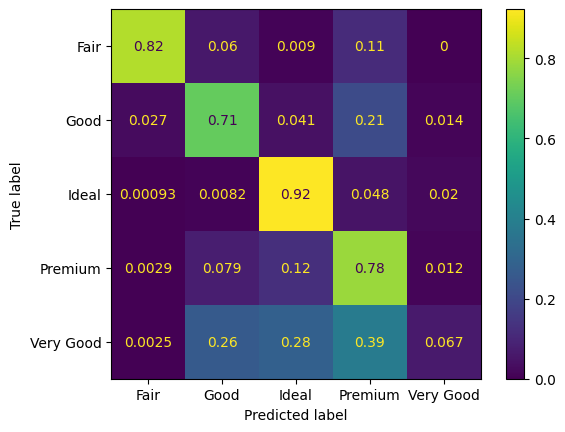

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test, rnd_for_bal.predict(X_test), normalize='true');

### Ejercicio 11

Muestra ahora la matriz de confusión, empleando la misma función, pero esta vez enseñando los porcentajes de distribució de los errores en la predicción, para eso emplea normalize = "pred" como argumeto y date cuenta de que las columnas son las que ahora suman el 100%. Comenta el resultado respecto a "Premium" como predicción y a lo que se equivoca respecto a "Very Good". 

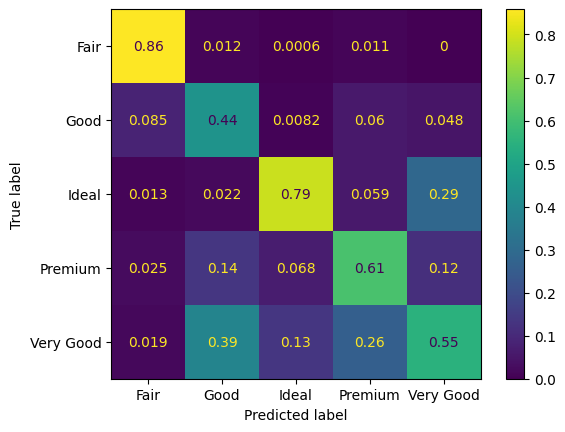

In [25]:
ConfusionMatrixDisplay.from_predictions(y_test, rnd_for_bal.predict(X_test), normalize='pred');

### Ejercicio 12

Dada la relación entre los errores de "Very Good" y "Prediction" que puedes haber observado en los ejercicios anteriores, una posible mejora es introducir un modelo que corrija esos errores, pero esa es la filosofía de los Gradient Boosted Trees. Provemos esa línea: Entrena un CatBoost con los hiperparámetros ajustados para que no emplee más de 5 niveles en sus árboles intermedios y para que balanceé las clases.

1. Obtener el "balanced_accuracy" primero con una validación cruzada.
2. Evaluálo después de contra el test.

In [26]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(max_depth=5, verbose=False, auto_class_weights='Balanced')


In [27]:
np.mean(cross_val_score(cat, X_train, y_train, cv=5, scoring='balanced_accuracy'))


0.7864038362819652

              precision    recall  f1-score   support

        Fair       0.87      0.93      0.90       335
        Good       0.70      0.80      0.74      1004
       Ideal       0.84      0.89      0.87      4292
     Premium       0.79      0.83      0.81      2775
   Very Good       0.69      0.53      0.60      2382

    accuracy                           0.79     10788
   macro avg       0.78      0.79      0.78     10788
weighted avg       0.78      0.79      0.78     10788



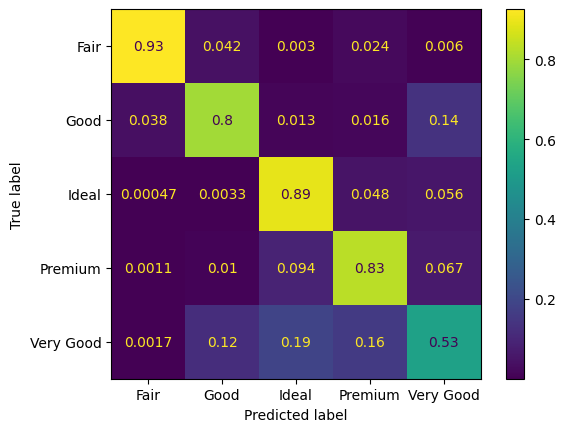

In [32]:
cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true");